You are a data scientist at LinkedIn. Your colleagues from Marketing want to organize an online marketing campaign for their client, a restaurant in the Bay area (San Francisco Bay area, not Brest Bay area, by the way). They have read a lot about social network analysis and ask you to find the 5 most influential people on the network who would be best to promote the restaurant.

You are a smart data scientist, and you know that influence is not enough. You have to find the users who are influencers but also located in the right area! As you know your dataset perfectly, you are aware that only 40% of the users have provided their location in their profile... But as you know about homophily: nodes that are connected to each other in a social network tend to be similar in their features. This property is captured by a popular proverb: “birds of a feather flock together.” So you have a plan: prepare your dataset to fill uncomplete profiles, you will use their neighbors' attributes!

Of course, a data scientists bring proofs, justify their results. Compare your strategy to fill the profile with the "ground truth" (i.e. real data, given in the coding material), and compare also different strategies to select the best one! We provide you with a baseline (known) method in order to compare your proposal with its (lower, of course lower) results. To measure the relevance of your profile filling strategy, you can use accuracy.

What could you do to test your detection of influencers? This step is called the evaluation of your model (cf. CRISP-DM steps). It is a very important step to decide whether you will deploy your method.... or if it will just remain a lab toy!

    Your challenge is to find influencers able to promote a restaurant in the Bay Area



In [1]:
import networkx as nx
# https://networkx.github.io/documentation/stable/reference/index.html
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib.cm import ScalarMappable

In [2]:
# Sub-problem: fill the profiles of 'empty' nodes
df_empty = pd.read_csv('empty.csv', sep='\t', header='infer')
df_empty.head()

,name
0,U27476
1,U4665
2,U14078
3,U9628
4,U9721


In [3]:
# Get a list from a Series
empty = df_empty['name'].drop_duplicates().tolist()
len(empty)

475

In [4]:
# Sub-problem: fill the profiles of 'empty' nodes
df_location = pd.read_csv('location_with_60percent_of_nodes_remoded.csv', sep='\t', header='infer')
df_location.head()

,name,location
0,U1313,norfolk virginia area
1,U8804,bologna area italy
2,U2649,urbana-champaign illinois area
3,U7310,greater seattle area
4,U22859,bengaluru area india


In [5]:
# Get a list from a Series
location = df_location['location'].drop_duplicates().tolist()
len(location)

89

In [6]:
# We use pandas dataframes to load attributes
# Nodes are characterized by a list of colleges, a list of employers, a list of location
# The order means nothing. Nothing allow us to determine the current employer...
df_e = pd.read_csv('employer_with_60percent_of_nodes_remoded.csv', sep='\t', header='infer')
df_e.head()

,name,employer
0,U1313,discovery education
1,U1313,ctb mcgraw-hill
2,U1313,university of charleston university of south c...
3,U1313,south carolina department of education
4,U1313,chesapeake va and sumter sc


In [7]:
df_college = pd.read_csv('college_with_60percent_of_nodes_remoded.csv', sep='\t', header='infer')
df_college.head()

,name,college
0,U1313,longwood university
1,U8804,universit&#xe0; di bologna
2,U2136,university of illinois at urbana-champaign
3,U6021,illinois wesleyan university
4,U7310,university of illinois at urbana-champaign


In [8]:
df_4 = pd.concat([df_empty, df_location], axis=0)
df_4

,name,location
0,U27476,NaN
1,U4665,NaN
2,U14078,NaN
3,U9628,NaN
4,U9721,NaN
...,...,...
331,U14007,urbana-champaign illinois area
332,U15197,urbana-champaign illinois area
333,U27777,china
334,U8828,urbana-champaign illinois area


In [9]:
df_5 = pd.concat([df_4, df_e], axis=0)
df_5

,name,location,employer
0,U27476,NaN,NaN
1,U4665,NaN,NaN
2,U14078,NaN,NaN
3,U9628,NaN,NaN
4,U9721,NaN,NaN
...,...,...,...
918,U15197,NaN,qualcomm innovation center inc
919,U15197,NaN,campus information technologies and educationa...
920,U15197,NaN,smartplay technologies
921,U27777,NaN,yuhuan taijie hardware co. ltd.


In [10]:
df_5 = pd.concat([df_5, df_college], axis=0)
df_5

,name,location,employer,college
0,U27476,NaN,NaN,NaN
1,U4665,NaN,NaN,NaN
2,U14078,NaN,NaN,NaN
3,U9628,NaN,NaN,NaN
4,U9721,NaN,NaN,NaN
...,...,...,...,...
237,U27761,NaN,NaN,shanghai jiao tong university
238,U18562,NaN,NaN,university of florida
239,U18562,NaN,NaN,florida international university
240,U15197,NaN,NaN,university of illinois at urbana-champaign


In [11]:
df_5['college'].value_counts()

university of illinois at urbana-champaign             66
shanghai jiao tong university                          16
bangladesh university of engineering and technology    10
tsinghua university                                     9
indian institute of technology bombay                   6
                                                       ..
baylor university                                       1
texas a&amp;m university                                1
can tho university vietnam                              1
universidad complutense de madrid                       1
depaul university                                       1
Name: college, Length: 109, dtype: int64

In [12]:
# How many nodes match san francisco bay area 
len(df_5.loc[df_5['location'].isin(['san francisco bay area']),:].drop_duplicates())

24

In [13]:
sf=df_5.loc[df_5['location'].isin(['san francisco bay area']),'name'].values
sf

array(['U15272', 'U27585', 'U27661', 'U27758', 'U27614', 'U7056',
       'U24084', 'U2761', 'U22771', 'U24113', 'U22803', 'U2622', 'U27642',
       'U24064', 'U7159', 'U16141', 'U7092', 'U7151', 'U2746', 'U8721',
       'U8050', 'U4568', 'U24224', 'U28772'], dtype=object)

In [14]:
# load the graph
# The graph is an extraction from LinkedIn Social Network
G = nx.read_gexf("mediumLinkedin.gexf")
print("%d nodes have no adress attributes among the %d users in the graph" % (G.number_of_nodes()-len(df_location[['name']].drop_duplicates()), G.number_of_nodes()))

475 nodes have no adress attributes among the 811 users in the graph


### Assortativity
nodes that are connected to each other in a social network tend to be similar in their features
 Social networks are often assortative. Networks where highdegree nodes tend to be connected to low-degree nodes and vice versa are
called disassortative

In [15]:
# assortativity coefficient: the Pearson correlation between the degrees of pairs of linked nodes.
r = nx.degree_assortativity_coefficient(G)
r

-0.22480574380333795

When the assortativity coefficient is positive, the network is
assortative, and when it is negative, the network is disassortative..

our network is dissasortative, because the assortativity coefficient is negative.  The Web, the Internet, food webs, and
other biological networks tend to be disassortative (book)

In [16]:
# calculate the correlation between the degree and its associatedneighbor connectivity:

import scipy.stats
knn_dict = nx.k_nearest_neighbors(G)
k, knn = list(knn_dict.keys()), list(knn_dict.values())
r, p_value = scipy.stats.pearsonr(k, knn)

In [17]:
naive_predicted_values={}

In [18]:
def naive_method(graph, empty, df_location):
  
    predicted_values={}
    for n in empty:
        nbrs_attr_values=[] 
        for nbr in graph.neighbors(n):
            # attribute values for the node nbr
            attr = df_location.loc[df_location.name == nbr ,'location'].values
            if attr.size > 0: #array not empty
                for val in attr:
                    nbrs_attr_values.append(val)
        predicted_values[n]=[]
        if nbrs_attr_values: # non empty list
            # count the number of occurrence each value and returns a dict
            cpt=Counter(nbrs_attr_values)
            # take the most represented attribute value among neighbors
            a,nb_occurrence=max(cpt.items(), key=lambda t: t[1])
            predicted_values[n].append(a)
    return predicted_values


In [19]:
naive_predicted_values = naive_method(G, empty, df_location)

In [20]:
#trasnform dict to df 
df_nv=pd.DataFrame.from_dict(naive_predicted_values , orient='index' ,columns=['location'])
df_nv.head()

,location
U27476,san francisco bay area
U4665,None
U14078,urbana-champaign illinois area
U9628,urbana-champaign illinois area
U9721,springfield illinois area


In [21]:
df_e_truth = pd.read_csv('./groundtruth/location.csv', sep='\t', header='infer')
df_e_truth.head()

,name,location
0,U27476,greater new york city area
1,U4665,greater chicago area
2,U1313,norfolk virginia area
3,U8804,bologna area italy
4,U14078,stockholm sweden


In [22]:
def evaluation_accuracy(groundtruth, pred):
    """    Compute the accuracy of your model.

     The accuracy is the proportion of true results.

    Parameters
    ----------
    groundtruth : pandas dataframe 
       Either location, employer or college dataframe. 
    pred : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values. 

    Returns
    -------
    out : float
       Accuracy.
    """
    true_positive_prediction=0
    predicted=0
    for p_key, p_value in pred.items():
        attr = groundtruth.loc[groundtruth.name == p_key ,groundtruth.columns[1]].values
        # if prediction is empty, e.g. [], and so is the groundtruth
        # May happen, we count it as a true prediction
        if not p_value and attr.size == 0:
            true_positive_prediction+=1
            predicted+=1
        # counts the number of good prediction for node p_key
        # here len(p_value)=1 but we could have tried to predict more values
        # if p_value == [], we add 0
        true_positive_prediction += len([c for c in p_value if c in attr])
        predicted += len([c for c in p_value])
    return true_positive_prediction*100/predicted
 

In [23]:
result=evaluation_accuracy(df_e_truth, naive_predicted_values)
print("%f%% of the predictions are true" % result)
print("Very poor result!!! Try to do better!!!!")

32.352941% of the predictions are true
Very poor result!!! Try to do better!!!!


In [24]:
GA=nx.from_pandas_edgelist(df_location,source='location', target='name')

In [25]:
print(nx.info(GA))

Name: 
Type: Graph
Number of nodes: 425
Number of edges: 336
Average degree:   1.5812


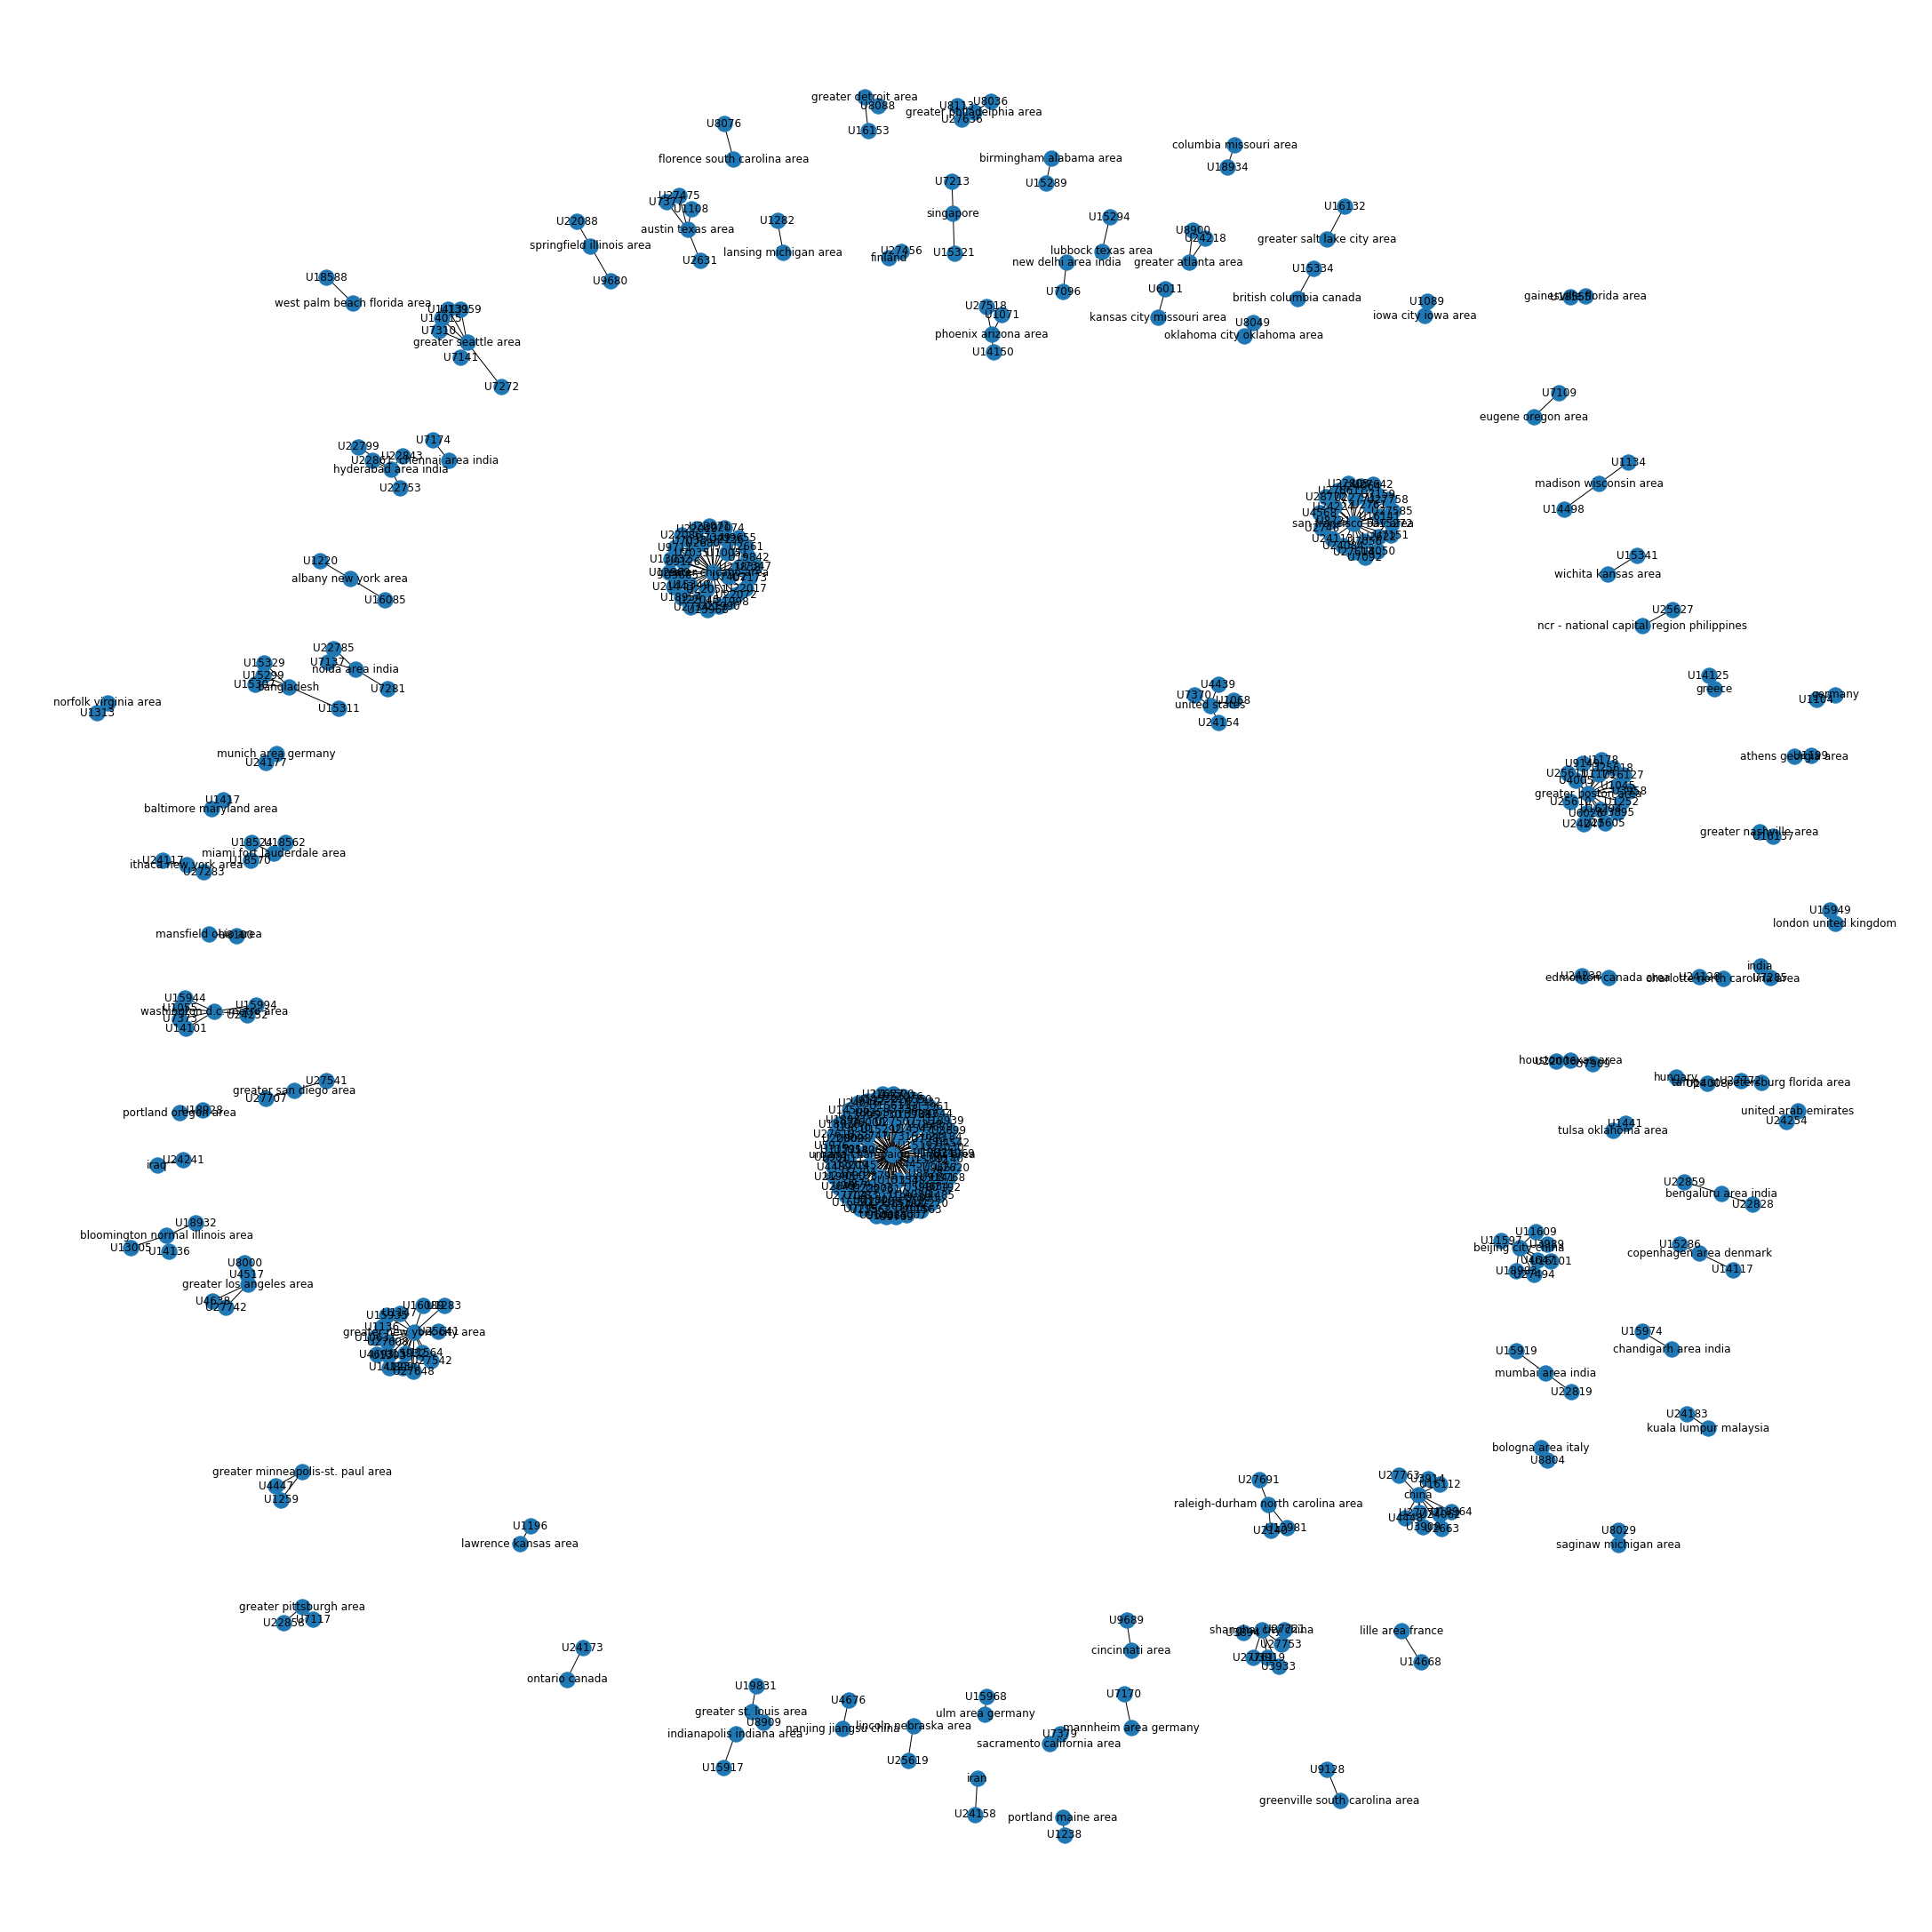

In [26]:
plt.figure(figsize=(30, 30))
nx.draw(GA,with_labels=True)
plt.show()


In [27]:
#A node has high betweenness if it occupies a special position in the
#network, such that it is an important station for the communication patterns
#running through the network.For that to happen, it is not necessary to have
#many neighbors 

In [28]:
PR_dict = nx.pagerank(G) # D is a DiGraph


#homophili

, in
particular geographic homophily: two people are more likely to know each
other if they live nearby.

### codes interessantessP segunda parte

: https://www.datacamp.com/community/tutorials/social-network-analysis-python

https://keras.io/examples/graph/gnn_citations/

### centrality

In [29]:
# % of connections this user has been with

degree_centrality=nx.degree_centrality(G)
sorted(degree_centrality.items(),key=lambda x:x[1],reverse=True)[:5]

[('U27287', 0.15061728395061727),
 ('U7024', 0.09135802469135802),
 ('U1045', 0.07160493827160494),
 ('U7972', 0.056790123456790124),
 ('U8670', 0.056790123456790124)]

In [35]:
# To see the nodes with the highest degree. Total of connections this users have been with

sorted_nodes_by_degree=sorted([(n,d) for n, d in G.degree()], key=lambda t: t[1], reverse= True)

five_influencers=[]
i=0
reach=0

while len(five_influencers)<5:
    location=''
    if str(sorted_nodes_by_degree[i][0]) not in empty:
        location=df_location.loc[df_location.name==str(sorted_nodes_by_degree[i][0]), 'location'].values
    else:
        location = naive_predicted_values[str(sorted_nodes_by_degree[i][0])]
        
    if location=='':
        print("ERROR")
    
    if location == 'san francisco bay area':
        five_influencers.append(str(sorted_nodes_by_degree[i][0]))
        reach+=int(sorted_nodes_by_degree[i][1])
        #print(location)
    i+=1
    
    
print("The 5 nodes with the highest degree are: ", five_influencers)
print("The reach of this algorithm is ", reach)

The 5 nodes with the highest degree are:  ['U4568', 'U27661', 'U16141', 'U15272', 'U22771']
The reach of this algorithm is  42


In [36]:
#quantite of connections per users:

me = "U22771"
print("%s has %d neighbors" % (me, G.degree(me)))


U22771 has 6 neighbors


In [37]:
# the betweenness centrality quantify the number of times a node acts as a bridge

betweenness_centrality=nx.betweenness_centrality(G)
sorted_nodes_by_degree=sorted(betweenness_centrality.items(),key=lambda x:x[1],reverse=True)
five_influencers=[]
i=0
reach_1=0
while len(five_influencers)<5:
    location=''
    if str(sorted_nodes_by_degree[i][0]) not in empty:
        location=df_location.loc[df_location.name==str(sorted_nodes_by_degree[i][0]), 'location'].values
    else:
        location = naive_predicted_values[str(sorted_nodes_by_degree[i][0])]
        
    if location=='':
        print("ERROR")
    
    if location == 'san francisco bay area':
        five_influencers.append(str(sorted_nodes_by_degree[i][0]))
        reach_1+=int(G.degree(sorted_nodes_by_degree[i][0]))
        #print(location)
    i+=1
    
    
print("The 5 nodes with the highest betweenness centrality are: ", five_influencers)
print("The reach of this algorithm is ", reach_1)
 

The 5 nodes with the highest betweenness centrality are:  ['U4568', 'U16141', 'U2622', 'U24084', 'U15272']
The reach of this algorithm is  32


In [38]:
# closenees centrality: The avarege distance from one node to any other nodes on the network. So the 
#user with the higest closenees centrality will have the lowest avarage distance to any other randon node. In NetworkX its reciprocal to avarage value.

closeness_centrality=nx.closeness_centrality(G)
sorted_nodes_by_degree=sorted(closeness_centrality.items(),key=lambda x:x[1],reverse=True)
five_influencers=[]
i=0
reach_2=0
while len(five_influencers)<5:
    location=''
    if str(sorted_nodes_by_degree[i][0]) not in empty:
        location=df_location.loc[df_location.name==str(sorted_nodes_by_degree[i][0]), 'location'].values
    else:
        location = naive_predicted_values[str(sorted_nodes_by_degree[i][0])]
        
    if location=='':
        print("ERROR")
    
    if location == 'san francisco bay area':
        five_influencers.append(str(sorted_nodes_by_degree[i][0]))
        reach_2+=int(G.degree(sorted_nodes_by_degree[i][0]))
        #print(location)
    i+=1
    
    
print("The 5 nodes with the highest closeness centrality are: ", five_influencers)
print("The reach of this algorithm is ", reach_2)
 

The 5 nodes with the highest closeness centrality are:  ['U4568', 'U24064', 'U27661', 'U24084', 'U27614']
The reach of this algorithm is  36


In [39]:
# eigenvector centrality :A node is high in eigenvector centrality if its connected to many other nodes who are 
# thenselves well connected. 

eigenvector_centrality=nx.eigenvector_centrality(G)
sorted_nodes_by_degree=sorted(eigenvector_centrality.items(),key=lambda x:x[1],reverse=True)
five_influencers=[]
i=0
reach_3=0

while len(five_influencers)<5:
    location=''
    if str(sorted_nodes_by_degree[i][0]) not in empty:
        location=df_location.loc[df_location.name==str(sorted_nodes_by_degree[i][0]), 'location'].values
    else:
        location = naive_predicted_values[str(sorted_nodes_by_degree[i][0])]
        
    if location=='':
        print("ERROR")
    
    if location == 'san francisco bay area':
        five_influencers.append(str(sorted_nodes_by_degree[i][0]))
        #print(location)
        reach_3+=int(G.degree(sorted_nodes_by_degree[i][0]))
    i+=1
    
    
print("The 5 nodes with the highest eigenvector centrality are: ", five_influencers)
print("The reach of this algorithm is ", reach_3)

The 5 nodes with the highest eigenvector centrality are:  ['U4568', 'U27661', 'U24064', 'U27614', 'U27585']
The reach of this algorithm is  36


In [40]:
me = "U27614"
print("%s has %d neighbors" % (me, G.degree(me)))


U27614 has 5 neighbors


In [41]:
for n in G.neighbors(me):
    print(n)

U27460
U27588
U27613
U27287
U27475


In [43]:
# page rank
page_rank=nx.pagerank(G)
sorted_nodes_by_degree=sorted(page_rank.items(),key=lambda x:x[1],reverse=True)
five_influencers=[]
i=0
reach_4=0

while len(five_influencers)<5:
    location=''
    if str(sorted_nodes_by_degree[i][0]) not in empty:
        location=df_location.loc[df_location.name==str(sorted_nodes_by_degree[i][0]), 'location'].values
    else:
        location = naive_predicted_values[str(sorted_nodes_by_degree[i][0])]
        
    if location=='':
        print("ERROR")
    
    if location == 'san francisco bay area':
        five_influencers.append(str(sorted_nodes_by_degree[i][0]))
        reach_4+=int(G.degree(sorted_nodes_by_degree[i][0]))
        #print(location)
    i+=1
    
    
print("The 5 nodes with the highest page rank centrality are: ", five_influencers)
print("The reach of this algorithm is ", reach_4)

The 5 nodes with the highest page rank centrality are:  ['U4568', 'U16141', 'U27661', 'U22771', 'U27614']
The reach of this algorithm is  41


In [44]:
# closenees centrality: The avarege distance from one node to any other nodes on the network. So the 
#user with the higest closenees centrality will have the lowest avarage distance to any other randon node. In NetworkX its reciprocal to avarage value.

closeness_centrality=nx.closeness_centrality(G)
sorted(closeness_centrality.items(),key=lambda x:x[1],reverse=True)[:5]

[('U27287', 0.2607855763039279),
 ('U2656', 0.2407847800237812),
 ('U4562', 0.23403640566310316),
 ('U7319', 0.2330264672036824),
 ('U4568', 0.23189235614085313)]

In [52]:
# avarage distance user ''U27287'.ie, the user average 'U27287' is connected to all other randon nodes by 3.
average=1/closeness_centrality['U27287']
average

3.8345679012345677

In [47]:
# the betweenness centrality quantify the number of times a node acts as a bridge
betweenness_centrality=nx.betweenness_centrality(G)
sorted(betweenness_centrality.items(),key=lambda x:x[1],reverse=True)[:5]

[('U27287', 0.4714778848757611),
 ('U7024', 0.2982615589321148),
 ('U11591', 0.2367332287634583),
 ('U7091', 0.19301616678984643),
 ('U8670', 0.1717989971049202)]

In [53]:
# eigenvector centrality :A node is high in eigenvector centrality if its connected to many other nodes who are 
# thenselves well connected. 
eigenvector_centrality=nx.eigenvector_centrality_numpy(G)
sorted(eigenvector_centrality.items(),key=lambda x:x[1],reverse=True)[:5]

[('U27287', 0.5730200560073089),
 ('U24045', 0.2204058112401598),
 ('U24504', 0.15500702198919808),
 ('U25563', 0.15484002088840948),
 ('U27471', 0.15394257456846355)]

In [54]:
#to scale the eigenvectors we have the user with the higest value and we scalle then all from there .

max_value=max(eigenvector_centrality.items(),key=lambda x:x[1])
ec_scaled={}
for k in eigenvector_centrality.keys():
    ec_scaled[k]=eigenvector_centrality[k]/max_value[1]
# scaled by the most central user
sorted(ec_scaled.items(),key=lambda x:x[1],reverse=True)[:5]

[('U27287', 1.0),
 ('U24045', 0.3846389125991578),
 ('U24504', 0.27050889469603656),
 ('U25563', 0.27021745445928075),
 ('U27471', 0.26865128533389415)]

In [51]:

# pagerank. 
pagerank=nx.pagerank(G)
sorted(pagerank.items(),key=lambda x:x[1],reverse=True)[:5]

[('U7024', 0.037107186403121994),
 ('U27287', 0.034483458893467316),
 ('U1045', 0.02572455854793547),
 ('U7091', 0.02135516263310395),
 ('U7972', 0.016755246219448718)]

We can also visualize the network such that the node color varies with Degree and node size with Betweenness Centrality.

(-0.9211482524871826,
 1.091483187675476,
 -0.8943832814693451,
 0.8399954736232758)

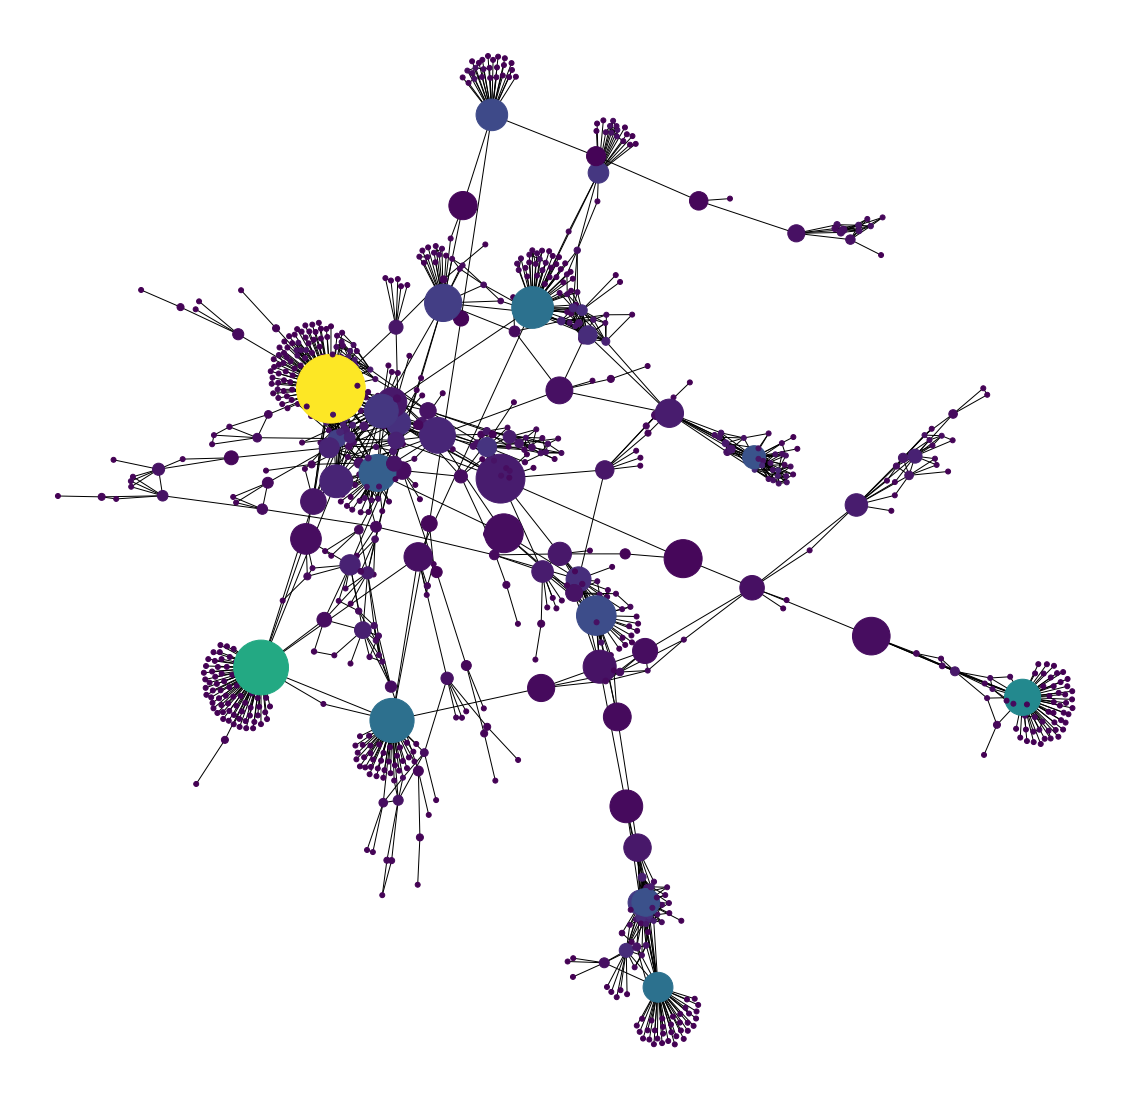

In [61]:
pos = nx.spring_layout(G)
betCent = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [20000.0 * G.degree(v) for v in G]
node_size =  [v * 10000 for v in betCent.values()]
plt.figure(figsize=(20,20))
nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

The nodes with the highest betweenness centrality using

### Link predictions

Jaccard coeficient: Analyse the proximity of nodes in the network. One way to measure proximity is to see what proportion 
of neighbors a pars of nodes share.It assumes that, nodes that are pretty similar in a someway, are gone be ones that will be connecteds in the future. It,acctualy look for neighbors between pairs of nodes. 
MAth: It looks at the intersection between 2 sets over the union of 2 sets.



In [68]:
pred_jc=nx.jaccard_coefficient(G)

In [74]:
pred_jc_dict={}
for u, v, p in pred_jc:
    pred_jc_dict[(u,v)]=p
    


In [ ]:
node='U22072'
f=[]
pred_jc_dict=sorted(pred_jc_dict.items(),key=lambda x:x[1],reverse=True)
for i in range (len(pred_jc_dict)):
    if len(f)<5:
        if list(pred_jc_dict)[i][0]==node:
            f.append(list(pred_jc_dict)[i][1])
    else:
        break
        
print(f)

preferential attachment

In [65]:
pred_pa=nx.preferential_attachment(G)

In [66]:
pred_pa_dict={}
for u, v, p in pred_pa:
    pred_pa_dict[(u,v)]=p

In [67]:
sorted(pred_pa_dict.items(),key=lambda x:x[1],reverse=True)[:5]

[(('U7024', 'U27287'), 9028),
 (('U1045', 'U27287'), 7076),
 (('U7972', 'U27287'), 5612),
 (('U8670', 'U27287'), 5612),
 (('U7091', 'U27287'), 5490)]